<a href="https://colab.research.google.com/github/MaximilianoRamirezN/lecturasIIC3633-2021/blob/main/practicos/pyRecLab_FunkSVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica de Sistemas Recomendadores: pyreclab - Funk's SVD

En este práctico implementaremos un recomendador basado en un algoritmo de factorización matricial propuesto por [Simon Funk](https://sifter.org/simon/journal/20061211.html).

Volveremos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile.

**Adaptado por**: Vladimir Araujo

**Material original de**: Denis Parra, Gabriel Sepúlveda, Antonio Ossa, Manuel Cartagena


## Configuración inicial

**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    275      0 --:--:--  0:00:01 --:--:--   275
100 1546k  100 1546k    0     0   994k      0  0:00:01  0:00:01 --:--:--  167M


In [2]:
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    473      0 --:--:-- --:--:-- --:--:--   474
100  385k  100  385k    0     0   406k      0 --:--:-- --:--:-- --:--:--  125M


In [3]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    674      0 --:--:-- --:--:-- --:--:--   674
100  230k  100  230k    0     0   314k      0 --:--:-- --:--:-- --:--:--  314k


**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y [`seaborn`](https://seaborn.pydata.org/index.html) utilizando `pip`.

In [4]:
!pip install pyreclab --upgrade
#!pip install seaborn --upgrade

In [5]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

## Antes de recomendar

**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [6]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [7]:
# Ahora queremos realizar una observación rápida de los datos
df_train.describe()

,userid,itemid,rating,timestamp
count,80000.000000,80000.000000,80000.000000,8.000000e+04
mean,494.508137,424.990487,3.526463,8.835467e+08
std,276.879511,330.564093,1.124429,5.379549e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,269.000000,174.000000,3.000000,8.794471e+08
50%,500.000000,321.000000,4.000000,8.828278e+08
75%,744.000000,630.000000,4.000000,8.884652e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [8]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [9]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [10]:
# Realizamos una inspección sobre estos datos (.info())
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [11]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs
pelis = [5,4,1]
df_items.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

**Paso 4:** Generemos algunos gráficos en relación a las películas.

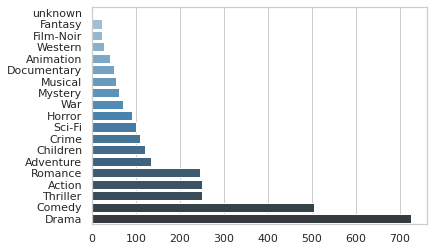

In [12]:
#Ignorar el warning
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

Antes de trabajar con SVD, responda las siguientes preguntas.

**Pregunta:** Explique cómo funciona SVD (como modelo, no piense en la implementación), y cómo funciona el método `train()` en  `pyreclab`





**Respuesta:** SVD es un método de factorización matricial, en el cual se considera una matriz $A \in \mathbb{R}^{n\times m}$ y se buscan matrices $U \in \mathbb{R}^{n\times n}$, $\Sigma \in \mathbb{R}^{n\times n}$ y $V \in \mathbb{R}^{m\times m}$. De tal forma que sea posible escribir $A$ como sigue $$A = U\Sigma V$$

En términos de sistemas recomendadores, podemos pensar $U$ como la matriz que contiene los factores latentes de los usuarios, $V$ como la matriz que contiene los factores latentes de los items, y finalmente $\Sigma$ como la matriz de los valores singulares de $A$, la cual nos da una noción de importancia de ciertas características, esto permite realizar reducción de dimensionalidad.

¿Como funciona el train?

## SVD

**Paso 5**: Tome un usuario, cualquiera, del dataset y reporte parte de sus gustos explícitamente (es decir, nombre de las películas, género, etc., no id). Para este mismo usuario, revise explícitamente las recomendaciones al llegar a la parametrización que reporta las mejores métricas.

In [13]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

df_items.loc[user_df['itemid'].values]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
13,Mighty Aphrodite (1995),30-Oct-1995,NaN,http://us.imdb.com/M/title-exact?Mighty%20Aphr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
19,Antonia's Line (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Antonia%20(1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
237,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
251,Shall We Dance? (1996),11-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Shall%20we%20...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
255,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
257,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [14]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.1)

In [15]:
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

MAE: 0.7206902498826668
RMSE: 0.9148458343642705


In [16]:
# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.11937710367131099
NDCG@20: 0.06653349922686574


In [17]:
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [1512, 1449, 169, 1367, 408, 483, 134, 1467, 1558, 318, 187, 1642, 114, 1500, 511, 1589, 1189, 12, 923, 189]


In [18]:
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1367,Faust (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Faust%20%2819...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
483,Casablanca (1942),01-Jan-1942,NaN,http://us.imdb.com/M/title-exact?Casablanca%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
134,Citizen Kane (1941),01-Jan-1941,NaN,http://us.imdb.com/M/title-exact?Citizen%20Kan...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1558,Aparajito (1956),29-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Aparajito%20(...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


**Paso 6:** Pruebe distintos valores de los parámetros de entrenamiento del algoritmo SVD:
- Número de factores
- Número de iteraciones máxima
- Learning rate
- Lambda

Describa cómo estos afectan las métricas y las recomendaciones hechas para el usuario que escogió: *COMPLETAR*

## Número de factores

In [23]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

n_factors = [50, 100, 150, 200]
top_n = 20


for factors in n_factors:

  print("n_factor=", factors, "\n")
  # Entrenamiento del modelo
  svd.train(factors=factors, maxiter=100, lr=0.01, lamb=0.1)

  # Testing de predicciones
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                dlmchar=b'\t',
                                header=False,
                                usercol=0,
                                itemcol=1,
                                ratingcol=2)

  print('MAE: {}\nRMSE: {}'.format(mae, rmse))

  # Testing de recomendaciones
  recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                            dlmchar=b'\t',
                                            header=False,
                                            usercol=0,
                                            itemcol=1,
                                            ratingcol=2,
                                            topn=top_n,
                                            relevance_threshold=2,
                                            includeRated=False)

  print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

  # Calcular las recomendaciones para el usuario escogido
  ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
  print('Recommendation for user {}: {}'.format(user_id, ranking))

  print("\n############################################################################\n")

n_factor= 50 

MAE: 0.7212955188429818
RMSE: 0.9166545409590753
MAP: 0.10547860469306433
NDCG@20: 0.05862182450755835
Recommendation for user 2: [1512, 1558, 1449, 1500, 408, 192, 1398, 12, 169, 1467, 1367, 611, 483, 654, 173, 963, 1642, 318, 174, 513]

############################################################################

n_factor= 100 

MAE: 0.7203995372391223
RMSE: 0.9143559587297161
MAP: 0.114326764953692
NDCG@20: 0.06427026309149024
Recommendation for user 2: [1512, 408, 1449, 1367, 169, 64, 963, 483, 223, 173, 1642, 1558, 1137, 12, 318, 480, 1467, 1064, 134, 174]

############################################################################

n_factor= 150 

MAE: 0.7203667001629657
RMSE: 0.9136384954746137
MAP: 0.12460130289943841
NDCG@20: 0.06961594779474285
Recommendation for user 2: [1512, 1449, 408, 169, 1367, 1589, 318, 12, 64, 1463, 480, 483, 963, 1467, 1642, 134, 923, 223, 511, 187]

############################################################################

n_facto

La variación del parámetro **_numero de factores_** no genera grandes cambios en las métricas utilizadas, y esto se refleja en que las recomendaciones son esencialmente las mismas salvo excepciones y el orden de recomendación.

## Número de iteraciones máxima

In [24]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

n_iter = [50, 100, 150, 200]
top_n = 20


for iter in n_iter:

  print("n_iter maxima=", iter, "\n")
  # Entrenamiento del modelo
  svd.train(factors=100, maxiter=iter, lr=0.01, lamb=0.1)

  # Testing de predicciones
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                dlmchar=b'\t',
                                header=False,
                                usercol=0,
                                itemcol=1,
                                ratingcol=2)

  print('MAE: {}\nRMSE: {}'.format(mae, rmse))

  # Testing de recomendaciones
  recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                            dlmchar=b'\t',
                                            header=False,
                                            usercol=0,
                                            itemcol=1,
                                            ratingcol=2,
                                            topn=top_n,
                                            relevance_threshold=2,
                                            includeRated=False)

  print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

  # Calcular las recomendaciones para el usuario escogido
  ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
  print('Recommendation for user {}: {}'.format(user_id, ranking))

  print("\n############################################################################\n")

n_iter maxima= 50 

MAE: 0.7188957864261418
RMSE: 0.9122807552898814
MAP: 0.13477422721995183
NDCG@20: 0.0767320047776468
Recommendation for user 2: [1449, 169, 1512, 408, 1367, 64, 114, 480, 134, 483, 513, 963, 12, 113, 1467, 657, 48, 611, 318, 1131]

############################################################################

n_iter maxima= 100 

MAE: 0.720412968575326
RMSE: 0.9143938028710923
MAP: 0.11682902580067485
NDCG@20: 0.06420048427461487
Recommendation for user 2: [1512, 1449, 408, 1398, 483, 1536, 169, 1558, 1500, 480, 134, 12, 1367, 1064, 1467, 1639, 513, 64, 923, 511]

############################################################################

n_iter maxima= 150 

MAE: 0.7210315377270543
RMSE: 0.914994195336015
MAP: 0.11299208116614408
NDCG@20: 0.0592616268008009
Recommendation for user 2: [1512, 1449, 169, 408, 1064, 1398, 64, 1367, 1642, 318, 134, 963, 483, 480, 12, 114, 172, 174, 511, 1405]

###########################################################################

Para el parámetro **_número de iteraciones máxima_**, se aprecia principalmente una disminución en la métrica $MAP$ a medida que incrementamos el número de iteraciones. Sin embargo no se aprecian grandes cambios en las recomendaciones, son esencialmente las mismas peliculas salvo excepciones y orden en las recomendaciones.

## Learning rate

In [25]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

l_rate = [0.01, 0.05, 0.1, 0.15]
top_n = 20


for l in l_rate:

  print("learning rate=", l, "\n")
  # Entrenamiento del modelo
  svd.train(factors=100, maxiter=100, lr=l, lamb=0.1)

  # Testing de predicciones
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                dlmchar=b'\t',
                                header=False,
                                usercol=0,
                                itemcol=1,
                                ratingcol=2)

  print('MAE: {}\nRMSE: {}'.format(mae, rmse))

  # Testing de recomendaciones
  recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                            dlmchar=b'\t',
                                            header=False,
                                            usercol=0,
                                            itemcol=1,
                                            ratingcol=2,
                                            topn=top_n,
                                            relevance_threshold=2,
                                            includeRated=False)

  print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

  # Calcular las recomendaciones para el usuario escogido
  ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
  print('Recommendation for user {}: {}'.format(user_id, ranking))

  print("\n############################################################################\n")

learning rate= 0.01 

MAE: 0.7201111732261813
RMSE: 0.9144832402342596
MAP: 0.11262819784037871
NDCG@20: 0.06416265277108314
Recommendation for user 2: [1449, 1512, 169, 64, 483, 134, 408, 1367, 48, 12, 318, 511, 480, 114, 174, 1524, 172, 178, 166, 654]

############################################################################

learning rate= 0.05 

MAE: 0.7377830421253224
RMSE: 0.9317164702176575
MAP: 0.12106688807902385
NDCG@20: 0.06510098919697793
Recommendation for user 2: [1512, 169, 1449, 408, 1398, 1558, 1463, 1500, 12, 480, 318, 64, 1467, 1122, 813, 1137, 189, 1642, 1367, 174]

############################################################################

learning rate= 0.1 

MAE: 0.7645512016013956
RMSE: 0.9618984785010634
MAP: 0.12384911181927727
NDCG@20: 0.05980973248389272
Recommendation for user 2: [1512, 169, 1449, 922, 187, 1240, 1450, 1064, 1558, 813, 136, 1398, 318, 1467, 357, 320, 1642, 1103, 98, 589]

################################################################

Para el parámetro **_Learning rate_** tenemos que valores muy grandes afectan las métricas de error $MAE$ y $RMSE$, además de disminuir el $NDCG@20$, aquí ya se notan efectos ligeramente mas fuertes en las recomendaciones, donde ciertas listas de recomendación tienen órdenes más distintos en posición de las recomendaciones.

## Lambda

In [26]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

lambdas = [0.05, 0.1, 0.2, 0.5]
top_n = 20


for lamb in lambdas:

  print("lambda=", lamb, "\n")
  # Entrenamiento del modelo
  svd.train(factors=100, maxiter=100, lr=0.01, lamb=lamb)

  # Testing de predicciones
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                dlmchar=b'\t',
                                header=False,
                                usercol=0,
                                itemcol=1,
                                ratingcol=2)

  print('MAE: {}\nRMSE: {}'.format(mae, rmse))

  # Testing de recomendaciones
  recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                            dlmchar=b'\t',
                                            header=False,
                                            usercol=0,
                                            itemcol=1,
                                            ratingcol=2,
                                            topn=top_n,
                                            relevance_threshold=2,
                                            includeRated=False)

  print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

  # Calcular las recomendaciones para el usuario escogido
  ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
  print('Recommendation for user {}: {}'.format(user_id, ranking))

  print("\n############################################################################\n")

lambda= 0.05 

MAE: 0.7328590542307954
RMSE: 0.9336236233718156
MAP: 0.15311116839982544
NDCG@20: 0.08141115915509434
Recommendation for user 2: [1512, 480, 408, 1558, 64, 481, 427, 1449, 169, 45, 479, 238, 483, 515, 320, 12, 487, 1642, 192, 1155]

############################################################################

lambda= 0.1 

MAE: 0.720650107662163
RMSE: 0.914518472237991
MAP: 0.11515319640450371
NDCG@20: 0.06431072065353971
Recommendation for user 2: [1512, 1449, 408, 169, 1642, 12, 1467, 480, 483, 318, 134, 1500, 64, 603, 119, 1558, 192, 1367, 1137, 1169]

############################################################################

lambda= 0.2 

MAE: 0.7426582019792332
RMSE: 0.9349947490208734
MAP: 0.03251076978500581
NDCG@20: 0.021395188569105144
Recommendation for user 2: [1512, 1467, 1449, 1500, 1367, 1536, 408, 1398, 1642, 814, 169, 1189, 1064, 114, 318, 64, 1599, 12, 1450, 483]

############################################################################

lambda= 0

Para el parámetro **_Lambda_**, tenemos que valores muy grandes afectan principalmente a las métricas $MAP$ y $NDCG@20$, provocando disminuciones en estas, sin embargo las recomendaciones son esencialmente las mismas salvo excepciones y ordenes de recomendación.

**Paso 7:** Genere un gráfico explorando todos los parámetros que ofrece el modelo `SVD`, donde se grafiquen los valores probados para cada parámetro y el RMSE obtenido para cada uno. Debe probar una cantidad razonable de valores buscando la mejor parametrización y entregar el notebook con dicha parametrización.



In [19]:
# Ejemplo
factor_values = [100, 150, 200] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for f in factor_values:
  svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.719728487592779, 0.7201697509498715, 0.7198915948457304]
[0.9140898458571622, 0.9130749815813188, 0.9132747000797372]


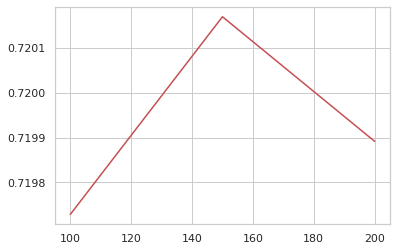

In [20]:
plt.plot(factor_values, mae_values, 'r-')
plt.show()

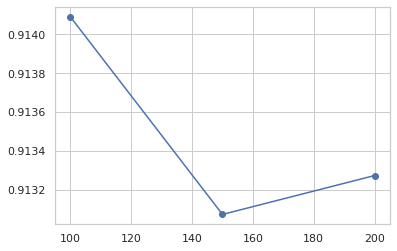

In [21]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.show()

**Paso 8:** Pruebe con otros valores y/o parámetros:

## Número de iteraciones máxima

In [27]:
n_iter = [100, 150, 200] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for n in n_iter:
  svd.train(factors=100, maxiter=n, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7204508645401296, 0.7214378470083317, 0.7212573339643401]
[0.9142154329016057, 0.9158741077070975, 0.9151887431635435]


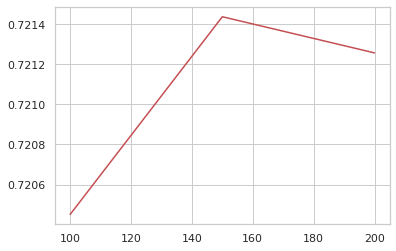

In [28]:
plt.plot(n_iter, mae_values, 'r-')
plt.show()

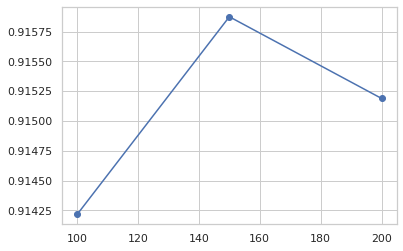

In [29]:
plt.plot(n_iter, rmse_values, 'bo-')
plt.show()

## Learning rate

In [30]:
lr = [0.01, 0.05, 0.075, 0.1] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for l in lr:
  svd.train(factors=100, maxiter=100, lr=l, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7209458982557123, 0.7380188674839172, 0.750890705343693, 0.76450043643583]
[0.915010340384566, 0.9321144188810854, 0.9460718959859776, 0.9618735728657761]


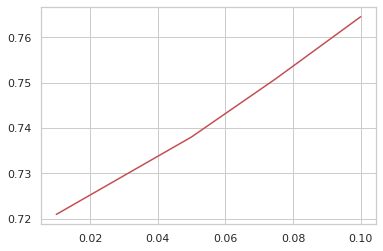

In [32]:
plt.plot(lr, mae_values, 'r-')
plt.show()

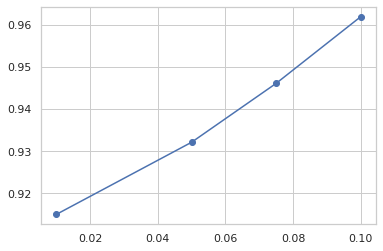

In [33]:
plt.plot(lr, rmse_values, 'bo-')
plt.show()

## Lambda 

In [34]:
lambdas = [0.05, 0.1, 0.2, 0.5] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for lamb in lambdas:
  svd.train(factors=100, maxiter=100, lr=0.01, lamb  = lamb)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7328765144537995, 0.7207531834587755, 0.7425785839859782, 0.7748522496905297]
[0.9331548311290815, 0.9147988953258888, 0.9350010116105145, 0.9644127550392464]


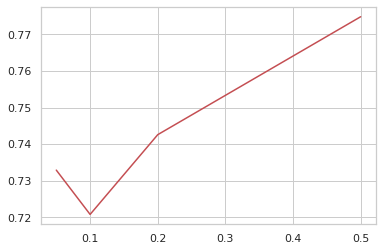

In [35]:
plt.plot(lambdas, mae_values, 'r-')
plt.show()

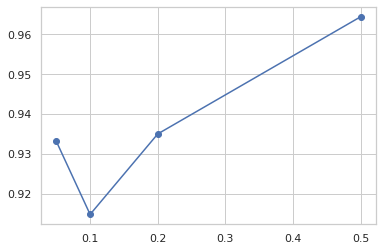

In [36]:
plt.plot(lambdas, rmse_values, 'bo-')
plt.show()

## Búsqueda de mejores parámetros

In [37]:
factor_values = [100, 150, 200] 
n_iter = [100, 150, 200] 
lr = [0.01, 0.05, 0.075, 0.1] 
lambdas = [0.05, 0.1, 0.2, 0.5] 


mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for factors in factor_values:
  for n in n_iter:
    for l in lr:
      for lamb in lambdas:
        svd.train(factors=factors, maxiter=n, lr=l, lamb = lamb)
  
        predlist, mae, rmse = svd.test(input_file='u2.test',
                                      dlmchar=b'\t',
                                      header=False,
                                      usercol=0,
                                      itemcol=1,
                                      ratingcol=2)
        
        mae_values.append((factors, n, l , lamb, mae))
        rmse_values.append((factors, n, l , lamb, rmse))

mae_values
rmse_values


[(100, 100, 0.01, 0.05, 0.934807732069414),
 (100, 100, 0.01, 0.1, 0.9143754495439649),
 (100, 100, 0.01, 0.2, 0.9350495052164859),
 (100, 100, 0.01, 0.5, 0.9644030118229836),
 (100, 100, 0.05, 0.05, 0.9425809662294279),
 (100, 100, 0.05, 0.1, 0.931927300389127),
 (100, 100, 0.05, 0.2, 0.956485108880745),
 (100, 100, 0.05, 0.5, 0.984766778434649),
 (100, 100, 0.075, 0.05, 0.9533346808457183),
 (100, 100, 0.075, 0.1, 0.9461479480159142),
 (100, 100, 0.075, 0.2, 0.9708060665208574),
 (100, 100, 0.075, 0.5, 0.9961943258647815),
 (100, 100, 0.1, 0.05, 0.9677684271222599),
 (100, 100, 0.1, 0.1, 0.9620238279774707),
 (100, 100, 0.1, 0.2, 0.9849524626253519),
 (100, 100, 0.1, 0.5, 1.0071235645595966),
 (100, 150, 0.01, 0.05, 0.9328284529784319),
 (100, 150, 0.01, 0.1, 0.9151942360866016),
 (100, 150, 0.01, 0.2, 0.9342484438374192),
 (100, 150, 0.01, 0.5, 0.964562663887494),
 (100, 150, 0.05, 0.05, 0.9418427709198931),
 (100, 150, 0.05, 0.1, 0.9318912606251096),
 (100, 150, 0.05, 0.2, 0.956405

## Parámetros que minimizan MAE

In [45]:
df_mae = pd.DataFrame(columns=['factors', 'n iter', 'learning rate', 'lambda', 'MAE'])

j=0
for i in mae_values:
  df_mae.loc[j]=i
  j+=1


df_mae.sort_values('MAE')

,factors,n iter,learning rate,lambda,MAE
97,200.0,100.0,0.01,0.1,0.720305
49,150.0,100.0,0.01,0.1,0.720409
1,100.0,100.0,0.01,0.1,0.720500
129,200.0,200.0,0.01,0.1,0.720758
65,150.0,150.0,0.01,0.1,0.720843
...,...,...,...,...,...
79,150.0,150.0,0.10,0.5,0.813396
47,100.0,200.0,0.10,0.5,0.813396
31,100.0,150.0,0.10,0.5,0.813396
95,150.0,200.0,0.10,0.5,0.813396


Así los parámetros que minimizan el MAE son 
> Factors = 200

> iter max = 100

> learning rate = 0.01

> lambda 0.1

## Parámetros que minimizan RMSE

In [47]:
df_rmse = pd.DataFrame(columns=['factors', 'n iter', 'learning rate', 'lambda', 'RMSE'])

j=0
for i in rmse_values:
  df_rmse.loc[j]=i
  j+=1


df_rmse.sort_values('RMSE')

,factors,n iter,learning rate,lambda,RMSE
97,200.0,100.0,0.01,0.1,0.913770
49,150.0,100.0,0.01,0.1,0.914198
113,200.0,150.0,0.01,0.1,0.914260
1,100.0,100.0,0.01,0.1,0.914375
129,200.0,200.0,0.01,0.1,0.914469
...,...,...,...,...,...
79,150.0,150.0,0.10,0.5,1.007124
47,100.0,200.0,0.10,0.5,1.007124
31,100.0,150.0,0.10,0.5,1.007124
95,150.0,200.0,0.10,0.5,1.007124


Mismos parámetros son los que minimizan el RMSE

Por lo que el modelo debe tener los parámetros

> Factors = 200

> iter max = 100

> learning rate = 0.01

> lambda 0.1